## Przygotowanie środowiska i danych

In [43]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [44]:
df_o = pd.read_csv("data/bank-balanced.csv")
print(df_o.shape)
df_o.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [45]:
df_o.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [46]:
target = 'deposit'
numFeatures = ['age', 'balance', 'duration', 'campaign', 'pdays','previous', 'day']
catFeatures = ['job', 'marital', 'education', 'default',  'housing', 'loan', 'contact',  'month', 'poutcome']

In [47]:
# Kopiowanie obiektu
df = df_o.copy()
# Słownik zawieracy mapy
mapy = {}
for feature in catFeatures:
# Obiekt do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
# Kolumna (tworzymy mapę) i od razu ją nakładamy na zmienną, na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df_o[feature])
# Mapa, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach   
    mapy[feature] = le

In [48]:
features = df.columns.tolist()
features.remove(target)
print(features)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [49]:
# Jakie klasy się utworzyły dla zmiennej  married
print(mapy['marital'].classes_)
# Odwrócenie mapowania
print(mapy['marital'].inverse_transform(df['marital']))
print(df_o["marital"].values)

['divorced' 'married' 'single']
['married' 'married' 'married' ... 'single' 'married' 'married']
['married' 'married' 'married' ... 'single' 'married' 'married']


## Przygotowanie wrappera do walidacji krzyżowej
Bazujemy na procedurze wykorzystanej do walidacji kNN. 
Stosujemy:
```clf = RandomForestClassifier(*args, **kwargs)``` 

In [50]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # Sklearn zwraca dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Indeksy w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices


## Pierwsze uruchomienie i przegląd hiperparametrów

In [51]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9120633918342885
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9206705884815203
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9211460733577608
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9108430127451866
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.9215899153297145
0.9172625963496941


Uzyskanie w każdym przypadku dopasowania 100% na zbiorze treningowym. Drzewa w lesie losowym bardzo mocno się przetrenowywały (dowolna głębokość). Zwiększamy liczbe drzew.

In [52]:
# Pętla po parametrze n_estimators
for k in [5, 10, 25, 50, 100, 200, 500, 1000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

5 0.9967996180817484 0.8781426914084364 0.11865692667331207
10 0.9995838573442228 0.8977571818373228 0.10182667550690006
25 0.9999872889879888 0.9104520709909532 0.08953521799703568
50 0.9999998893082228 0.915498712452151 0.08450117685607184
100 1.0 0.9172625963496941 0.08273740365030591
200 1.0 0.91835310780829 0.08164689219170995
500 1.0 0.9185454575127533 0.0814545424872467
1000 1.0 0.9186900993261761 0.08130990067382393


Random Forest nie przetrenowuje się mocniej wraz ze wzrostem liczby drzew. 
Są od siebie w pełni niezależne. 
Obserwujemy malejące krańcowe korzyści płynące z większej liczby drzew. 
Pozostajemy na 100 drzewach. 

In [53]:
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.8607333808146999 0.8581649560975702 0.0025684247171297026
4 0.8936940355103637 0.8872820188275904 0.006412016682773358
6 0.9169055075144918 0.9018813751485426 0.015024132365949239
8 0.9425071143421799 0.909976013149403 0.03253110119277691
10 0.9674590740898426 0.9149029967758908 0.05255607731395173
12 0.9859798340300066 0.9159709344584902 0.07000889957151635
14 0.9960079791951113 0.9174383296955 0.07856964949961132
16 0.9994779649755341 0.9174648432442097 0.08201312173132436
18 0.9999780952041168 0.9174353744197397 0.08254272078437719
20 0.9999998994206433 0.9170143607627443 0.08298553865789893


Algorytm skutecznie korzysta nawet z bardzo głębkoich drzew. Wraz ze zwiększaniem głębokości drzew zwiększa się przetrenowanie modelu. Przyjrzyjmy się kolejnemu hiperparametrowi - liczby zmiennych w pojedynczym drzewie: algorytm automatycznie ograniczy liczbę zmiennych na dane drzewo ustalać liczbę jako ```sqrt(n_features)```.

In [77]:
# lizczba zmiennych objaśniających
print(len(features))

16


In [78]:
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=10,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.9604447494954463 0.9094263605997155 0.05101838889573085
4 0.9674590740898426 0.9149029967758908 0.05255607731395173
6 0.9709138547314892 0.9142296636086881 0.0566841911228011
8 0.9726111836963962 0.9140343949185187 0.05857678877787753
10 0.9739197094454465 0.9133126989614219 0.060607010484024615
12 0.9744041433638652 0.9133894908673452 0.06101465249651994
14 0.9746075510524485 0.9130150318445273 0.06159251920792119
16 0.9746680926925398 0.9124576482662009 0.06221044442633894


Reguła kciuka (4 zmienne)! W dwóch kolejnych pętlach sprawdzamy działanie `min_samples_split` oraz `min_samples_leaf`.

In [79]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=10,
                                                                    max_features=4,
                                                                    min_samples_split=k)
    print(k, np.mean(testResults))

2 0.9149029967758908
4 0.9140411035587169
6 0.9146729120724991
8 0.9141739815122089
10 0.9140204901812657
15 0.9142799998393369
20 0.9138048035472158
30 0.9132202007513776


Testujemy wyłącznie wartości 1 i 2.

In [80]:
for k in [1, 2, 4]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100, max_depth=10,
                                                                    max_features=4,
                                                                    min_samples_split=6, min_samples_leaf=k)
    print(k, np.mean(testResults))

1 0.9146729120724991
2 0.9137833871964226
4 0.913460125361396


Najlepszy wynik - przy głębokości 20, maksymalnej liczbie featerów 4, obserwacji przed splitem 4 i min w liściu po splicie 1. Dla tych parametrów (ale większej liczby drzew) zapisujemy predykcje  modelu i porównujemy z wczesniejszymi wynikami.

In [104]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=200, max_depth=10,
                                                                    max_features=4,
                                                                    min_samples_split=4, min_samples_leaf=1)
print("k: ", k, "np.mean: ", np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

k:  (0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11162, dtype: int32, 0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 11162, dtype: int32) np.mean:  0.9146164442559062


In [105]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)
    
# Wczytajmy też wcześniej zapisane modele
with open("model_ekonometria_1.p", "rb") as fp:
    modelEkonometria = pickle.load(fp)
    
with open("model_svm_1.p", "rb") as fp:
    modelSVM = pickle.load(fp)
    
with open("model_kNN_1.p", "rb") as fp:
    modelkNN = pickle.load(fp)

In [106]:
from sklearn.metrics import roc_curve, roc_auc_score

def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''
    
    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=2, label=f'{label}: {rocScore}')
        
    # Krzywa 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Marginesy do zakresu, aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()


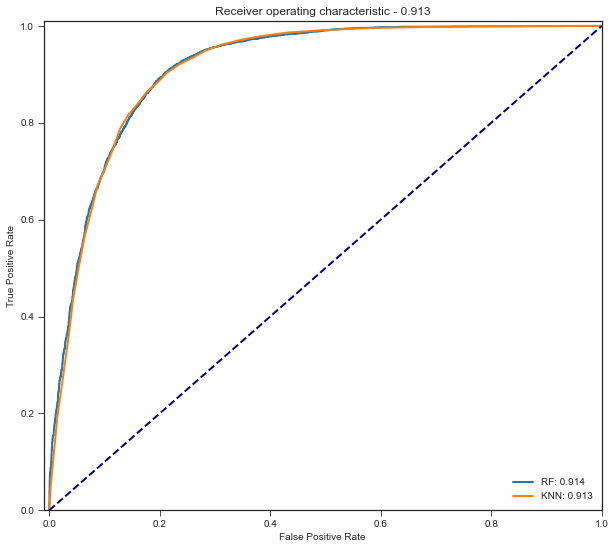

In [107]:
res2plot = []
true = (df[target]=="yes").astype(int).sort_index()
for result in [modelRF, modelkNN]:
    # Tworzymy wektor predykcji tworząc serię pandasa, a następnie sortujemy indeks
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# Wywołujemy funkcję do rysowania
plotROCs(res2plot)

## Szukanie optymalnych wartości hiperparametrów

In [115]:
# Przygotowujemy listę do zapisywnia wyników
results = []

In [116]:
import random
# Petla, w której będziemy iterować kolejne wyszukiwania.
for k in range(50):
    # Słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(6, 22),
        "max_features" : random.randint(2, 12),
        "min_samples_split" : random.randint(2, 9),
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy()))
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 18, 'max_features': 6, 'min_samples_split': 9, 'min_samples_leaf': 9} 0.9158512687744803
{'max_depth': 21, 'max_features': 4, 'min_samples_split': 4, 'min_samples_leaf': 3} 0.9174611248069485
{'max_depth': 8, 'max_features': 6, 'min_samples_split': 7, 'min_samples_leaf': 4} 0.9098282063185275
{'max_depth': 16, 'max_features': 8, 'min_samples_split': 6, 'min_samples_leaf': 4} 0.9182867172597529
{'max_depth': 10, 'max_features': 9, 'min_samples_split': 8, 'min_samples_leaf': 8} 0.913658516796367
{'max_depth': 16, 'max_features': 2, 'min_samples_split': 5, 'min_samples_leaf': 5} 0.9113370628486124
{'max_depth': 21, 'max_features': 10, 'min_samples_split': 7, 'min_samples_leaf': 5} 0.9172274280466859
{'max_depth': 18, 'max_features': 8, 'min_samples_split': 9, 'min_samples_leaf': 6} 0.916119110482757
{'max_depth': 8, 'max_features': 10, 'min_samples_split': 9, 'min_samples_leaf': 6} 0.9092050034900773
{'max_depth': 18, 'max_features': 7, 'min_samples_split': 3, 'min_samples_l

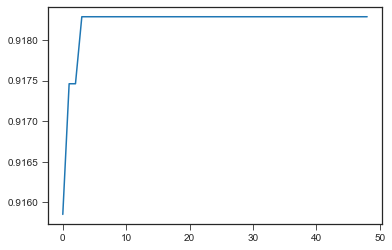

In [117]:
# Jak z czasem poprawiał się najlepszy wynik:
bestHistory = []
for k in range(1,len(results)):
    # List comprehension: dla k pierwszych wartości zwróć maximum
    bestHistory.append(np.max([x for x, y in sorted(results[:k], key=lambda x: x[0], reverse=True)]))
# Wykres historii
plt.plot(bestHistory)

## Feature importance
Dodajemy parametr `saveModels = False`.

In [118]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, saveModels = False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Aby oszczędzać pamięć, informacja o foldach to wyłącznie numery wierszy
    testResults = []
    
    # Dodajemy informację o wynikach na zbiorze treningowym
    trainResults = []
    
    # Przechowujemy  predykcje dla poszczególnych foldów
    predictions = []
    # Indeksy w oryginalnym zbiorze danych
    indices = []
    
    # Przygotowjemy liste modeli do zachowania
    models = []
    
    # Pętla walidująca modele
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # Sklearn zwraca dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowujemy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Indeksy w oryginalnym dataframe
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania metryką ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]=="yes").astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]=="yes").astype(int), preds)
        
        # Zapisanie wyników z iteracji
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
        # Zapisanie wyników do listy models
        if saveModels:
            models.append(clf)
    
    # Lista zwracanych wyników - zwróćmy uwagę na nowy obiekt models
    return trainResults, testResults, predictions, indices, models

In [120]:
trainResults, testResults, predictions, indices, models = CVTestRFClass(n_estimators=500, max_depth=20,
                                                                    max_features=4,
                                                                    min_samples_split=4, min_samples_leaf=1,
                                                                        saveModels=True)

In [122]:
imps = list(zip(models[0].feature_importances_, features))
imps.sort(reverse=True)
imps

[(0.3890581131768351, 'duration'),
 (0.08217577014964114, 'balance'),
 (0.08102766112571382, 'month'),
 (0.07819362432128948, 'age'),
 (0.06730735129692861, 'day'),
 (0.04889165989909755, 'contact'),
 (0.04471833497188696, 'pdays'),
 (0.037793307643543154, 'poutcome'),
 (0.03544606500027648, 'job'),
 (0.033220268296325704, 'housing'),
 (0.031953364644833185, 'campaign'),
 (0.022683025505984115, 'previous'),
 (0.01957689973235214, 'education'),
 (0.016099229950782685, 'marital'),
 (0.010637314169979106, 'loan'),
 (0.0012180101145306008, 'default')]

In [123]:
imps = list(zip(models[1].feature_importances_, features))
imps.sort(reverse=True)
imps

[(0.38267876987594335, 'duration'),
 (0.08508754054745363, 'month'),
 (0.08194437879556453, 'balance'),
 (0.07816998364268088, 'age'),
 (0.0682054938484369, 'day'),
 (0.04831179363013494, 'contact'),
 (0.04589949311710751, 'pdays'),
 (0.03698569244688108, 'poutcome'),
 (0.034962444252451805, 'job'),
 (0.0338120100380233, 'housing'),
 (0.0314370550501223, 'campaign'),
 (0.02478156071419787, 'previous'),
 (0.020000269764744456, 'education'),
 (0.016491210960269852, 'marital'),
 (0.010090183704059539, 'loan'),
 (0.001142119611928118, 'default')]

Uzyskujemy dosyć podobne wnioski jak w przypadku analizy z uzyciem algorytmu kNN. 
Duration jest zdecydowanie najważniejszą zmienną. 
Zmienne: age, day i balance również okazywały się być istotne w obydwu przypadkach.